In [15]:

!pip install torch torchvision scikit-learn matplotlib numpy


In [2]:
# Core imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [3]:
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [4]:
# Dataset parameters
N_SAMPLES = 5000
N_FEATURES = 10
ANOMALY_RATIO = 0.03  # 3%

# Normal data: mixture of Gaussians (multimodal)
normal_1 = np.random.normal(loc=0, scale=1, size=(int(N_SAMPLES*0.6), N_FEATURES))
normal_2 = np.random.normal(loc=4, scale=1.5, size=(int(N_SAMPLES*0.37), N_FEATURES))

normal_data = np.vstack([normal_1, normal_2])

# Anomalies: far-away distribution
anomalies = np.random.uniform(low=-10, high=10,
                              size=(int(N_SAMPLES*ANOMALY_RATIO), N_FEATURES))

# Combine
X = np.vstack([normal_data, anomalies])
y = np.hstack([np.zeros(len(normal_data)), np.ones(len(anomalies))])  # 1 = anomaly

# Shuffle
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

print("Dataset shape:", X.shape)
print("Anomaly count:", y.sum())


Dataset shape: (5000, 10)
Anomaly count: 150.0


In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_test = torch.tensor(y_test, dtype=torch.int)


In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.mu = nn.Linear(16, latent_dim)
        self.logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


In [7]:
def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')

    # KL Divergence
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_div


In [8]:
LATENT_DIM = 3
BETA = 1.0
LR = 1e-3
EPOCHS = 50

vae = VAE(N_FEATURES, LATENT_DIM).to(device)
optimizer = optim.Adam(vae.parameters(), lr=LR)

losses = []

for epoch in range(EPOCHS):
    vae.train()
    optimizer.zero_grad()

    x_hat, mu, logvar = vae(X_train)
    loss = vae_loss(X_train, x_hat, mu, logvar, beta=BETA)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 8.5384
Epoch 10, Loss: 8.2810
Epoch 20, Loss: 7.9712
Epoch 30, Loss: 7.3860
Epoch 40, Loss: 6.2269


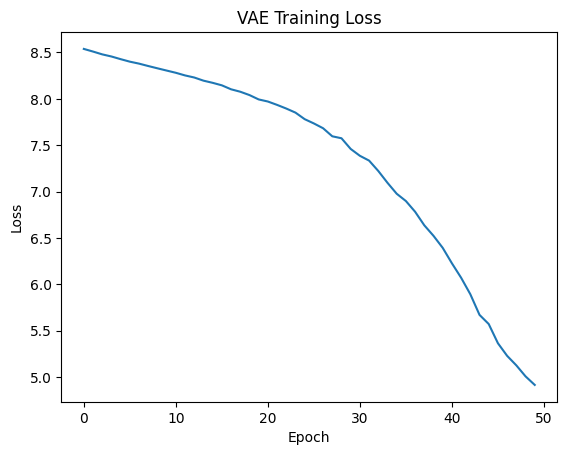

In [9]:
plt.plot(losses)
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [10]:
vae.eval()
with torch.no_grad():
    x_hat_test, _, _ = vae(X_test)
    recon_error = torch.mean((X_test - x_hat_test) ** 2, dim=1)

recon_error = recon_error.cpu().numpy()


In [11]:
# Threshold = 95th percentile of reconstruction error
threshold = np.percentile(recon_error, 95)

y_pred = (recon_error > threshold).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("VAE Performance:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


VAE Performance:
Precision: 0.6
Recall: 1.0
F1 Score: 0.75


In [12]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [13]:
ae = Autoencoder(N_FEATURES).to(device)
optimizer = optim.Adam(ae.parameters(), lr=LR)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    x_hat = ae(X_train)
    loss = nn.functional.mse_loss(x_hat, X_train)
    loss.backward()
    optimizer.step()


In [14]:
ae.eval()
with torch.no_grad():
    x_hat_ae = ae(X_test)
    ae_error = torch.mean((X_test - x_hat_ae) ** 2, dim=1).cpu().numpy()

threshold_ae = np.percentile(ae_error, 95)
y_pred_ae = (ae_error > threshold_ae).astype(int)

print("Baseline AE F1:",
      f1_score(y_test, y_pred_ae))


Baseline AE F1: 0.75
